# Optimization under Uncertainty on the Branin Function

In [1]:
import sys
sys.path.insert(1, '../')

import numpy as np
from bayesopt import BayesianOptimization

from riskkernel import Normal_SEKernel
from surrogate import GaussianProcessRiskNeutral, GaussianProcessRegressor, CVaR
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, RBF

from strategy import EIStrategy, SRBFStrategy, RandomStrategy
from experimental_design import SymmetricLatinHypercube as SLHC
import matplotlib.pyplot as plt

In [22]:
"""Branin Function
3 global minima at (-pi,12.275), (pi,2.275), (9.42,2.475) with f(x) = 0.397

"""
A, B, C, R, S, T = 1.0, 5.1/(4*np.pi**2), 5/np.pi, 6.0, 10.0, 1.0/(8*np.pi)
f = lambda x: A*(x[1]-B*x[0]**2+C*x[0]-R)**2 +S*(1.0-T)*np.cos(x[0])+S

# just for plotting...easier to evaluate with meshgrid
g = lambda x,y: A*(y-B*x**2+C*x-R)**2 +S*(1.0-T)*np.cos(x)+S

# dimension
dim        = 2

# make sure minima are in the feasible region
lb         = np.array([-5.0,0.0])
ub         = np.array([10.0,15.0])

# maximum evaluations
max_evals  = 400

# uncertainty variance
var    = 0.1

No handles with labels found to put in legend.


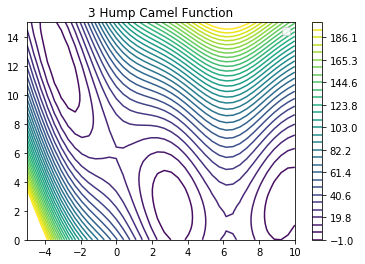

In [18]:
# plot the function
Ntest = 40
x = np.linspace(lb[0],ub[0],Ntest)
y = np.linspace(lb[1],ub[1],Ntest)
xx,yy = np.meshgrid(x,y)
Z   = g(xx,yy)
plt.contour(xx,yy,Z,np.linspace(-1,200,30))
plt.colorbar()

# plot the optimum
#plt.scatter(xopt[0],xopt[1],color='r',s=150, marker=(5,1),label='Risk Neutral Optimum')

plt.title('3 Hump Camel Function')
plt.legend()
plt.show()

In [15]:
# experimental design
initial_num_pts    = int(0.6*max_evals) # initial evaluations
exp_design = SLHC(dim, initial_num_pts)

# strategy
strategy   = SRBFStrategy(lb,ub)

# uncertainty covariance
K      = var*np.eye(dim)

# risk-neutral GP kernel
kernel     = Normal_SEKernel(K)
# tweak kernel hyperparameter bounds b/c branin is ill-conditioned problem
kernel.GPkernel = ConstantKernel(1, (1e-3, 1e4)) * RBF(1, (0.001, 100)) + \
                  WhiteKernel(1e-3, (1e-4, 1e-2))
surrogate  = GaussianProcessRiskNeutral(kernel)

# initialize surrogate
#kernel = ConstantKernel(1, (1e-3, 1e4)) * RBF(1, (0.001, 100)) + \
          #WhiteKernel(1e-3, (1e-6, 1e-2))
#surrogate = GaussianProcessRegressor(kernel =kernel)


# initialize the problem
problem    = BayesianOptimization(f,dim, max_evals, exp_design, strategy, surrogate,lb, ub)

# solve the problem
xopt,fopt  = problem.minimize()

/home/padidar/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.53379272e+01, -4.00699414e-02,  7.34818692e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 22, 'warnflag': 2}
  ConvergenceWarning)
/home/padidar/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.56365578e+01,  3.43695137e-04,  7.93819629e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)
/home/padidar/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.57126838e+01,  1.39988261e-03,  8.07935930e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 20, 'warnflag': 2}
  Conver

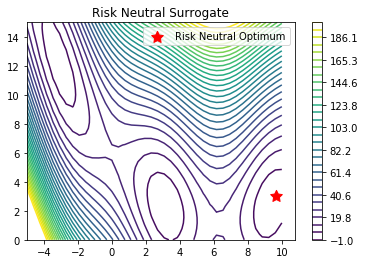

In [19]:
# plot the surrogate
X_grid = np.c_[ np.ravel(xx), np.ravel(yy) ]
z = surrogate.predict(X_grid)
z = z.reshape(xx.shape)

plt.contour(xx,yy,z,np.linspace(-1,200,30))
plt.colorbar()

# plot the optimum
plt.scatter(xopt[0],xopt[1],color='r',s=150, marker=(5,1),label='Risk Neutral Optimum')
plt.legend()
plt.title('Risk Neutral Surrogate')
plt.show()

In [20]:
# experimental design
initial_num_pts    = int(0.6*max_evals) # initial evaluations
exp_design = SLHC(dim, initial_num_pts)

# strategy
strategy   = SRBFStrategy(lb,ub)

#uncertainty information 
mu         = 0.0
sigma      = np.sqrt(var)
p = lambda num_pts: np.random.normal(mu, sigma, (num_pts,dim))

# Monte Carlo parameters
num_points_MC = 2000

# beta weighting
beta = 0.95

# surrogate
kernel = ConstantKernel(1, (1e-3, 1e4)) * RBF(1, (0.001, 100)) + \
    WhiteKernel(1e-3, (1e-4, 1e-2))
surrogate = CVaR(kernel, p, beta, num_points_MC)

# initialize the problem
problem    = BayesianOptimization(f,dim, max_evals, exp_design, strategy, surrogate,lb, ub)

# solve the problem
xopt,fopt  = problem.minimize()

/home/padidar/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.54579108e+01, -2.62124100e-04,  6.07017726e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 63, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)
/home/padidar/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.63121753e+01,  2.65774322e-02,  6.90640505e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 23, 'warnflag': 2}
  ConvergenceWarning)
/home/padidar/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.64179634e+01, -2.60463916e-04,  7.17196908e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 20, 'warnflag': 2}
  Conver

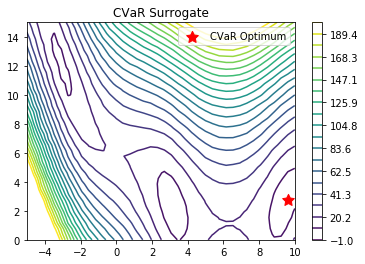

In [21]:
# plot the surrogate
X_grid = np.c_[ np.ravel(xx), np.ravel(yy) ]
z = surrogate.predict(X_grid)
z = z.reshape(xx.shape)

plt.contour(xx,yy,z,np.linspace(-1,200,20))
plt.colorbar()

# plot the optimum
plt.scatter(xopt[0],xopt[1],color='r',s=150, marker=(5,1),label='CVaR Optimum')
plt.legend()
plt.title('CVaR Surrogate')
plt.show()